In [1]:

import os
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
import quantstats as qs
import copy
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt import risk_models
from pypfopt import expected_returns
from pypfopt import objective_functions
from datetime import datetime, timedelta
from pypfopt.risk_models import CovarianceShrinkage
from pypfopt import CLA, plotting
from pypfopt import hierarchical_portfolio
from pypfopt import plotting
from metrics import *


DATA_DIR = (os.getcwd() + "/data/")
PREDICTION_DIR = (os.getcwd() + "/predictions_new/")
start_date = '2014-01-01'
end_date = "2019-11-30"
# Get fundamental data for each stock in the ticker and append to the dataframe




def get_all_symbols():
    return [v.strip('.csv') for v in os.listdir(DATA_DIR)]

def get_current_predictions():
    return [v.strip('_predictions.csv') for v in os.listdir(PREDICTION_DIR)]


tickers = get_all_symbols()
predicted_tickers = get_current_predictions()

sample_index = pd.read_csv(DATA_DIR + 'AAPL.csv', index_col='Date', parse_dates=True)
mask = (sample_index.index >= start_date) & (sample_index.index <= end_date)
sample_index = sample_index.loc[mask]


In [4]:
def get_top_n_tickers(year, month, n):
    #print("Getting top n tickers for year: " + str(year) + " month: " + str(month))
    results = []
    for ticker in get_current_predictions():
        df = pd.read_csv(PREDICTION_DIR + ticker + '_predictions.csv', index_col='Date', parse_dates=True)
        mask = (df.index.year == year) & (df.index.month == month)
        df = df.loc[mask]
        #print(ticker, df['Next Month Returns Predictions'][0])
        results.append((ticker, df['Next Month Returns Predictions'][0]))
    
    #print(results)
    results.sort(key=lambda x: x[1], reverse=True)
    tickers = [i[0] for i in results[:n]]
    pred_vector = [i[1] for i in results[:n]]
    #print(pred_vector)
    #print(year, month)
    return tickers, pred_vector

def get_close_prices(year, month, d, tickers):
    df = pd.DataFrame()
    days = d * 365
    target_date = datetime(year, month, 1) - timedelta(days=days)
    for ticker in tickers:
        data = pd.read_csv(DATA_DIR + ticker + '.csv',
                           index_col='Date', parse_dates=True)
        mask = (data.index >= target_date) & (data.index <= datetime(year, month, 1))
        data = data.loc[mask]
        df[ticker] = data['Close']
        df.index = data.index

    return df


def generate_predicted_historical_returns(year, month, d, tickers):
    d = d * 365
    target_date = datetime(year, month, 1) - timedelta(days=d)
    df = pd.DataFrame()
    for ticker in tickers:
        prediction = pd.read_csv(PREDICTION_DIR + ticker + '_predictions.csv', index_col='Date', parse_dates=True)
        mask = (prediction.index >= target_date) & (prediction.index <= datetime(year, month, 1))
        prediction = prediction.loc[mask]
        df[ticker] = prediction['Next Month Returns Predictions']
        df.index = prediction.index
    return df
    


def get_top_n_tickers_combined(start_year, start_month, end_year, end_month, n):
    output = []
    pred_vectors = []
    curr_year, curr_month = start_year, start_month
    while not (curr_year > end_year or (curr_year == end_year and curr_month > end_month)):
        tickers, pred_vector = get_top_n_tickers(curr_year, curr_month, n)
        output.append(tickers)
        pred_vectors.append(pred_vector)
        
        if curr_month == 12:
            curr_month = 1
            curr_year += 1
        else:
            curr_month += 1
    return output, pred_vectors


def generate_close_data(tickers, month, year):
    df = pd.DataFrame()
    for ticker in tickers:
        data = pd.read_csv(DATA_DIR + ticker + '.csv',
                           index_col='Date', parse_dates=True)
        data = data.loc[data.index.month == month]
        data = data.loc[data.index.year == year]
        df[ticker] = data['Close']
        df.index = data.index
    return df


def generate_all_close_data(tickers, start_year, start_month, end_year, end_month):
    output = pd.DataFrame()
    curr_year, curr_month = start_year, start_month
    curr_idx = 0
    while not (curr_year > end_year or (curr_year == end_year and curr_month > end_month)):
        data = generate_close_data(tickers[curr_idx], curr_month, curr_year)
        output = pd.concat([output, data], axis=0, join='outer')
        output = output.reset_index(drop=True)
        if curr_month == 12:
            curr_month = 1
            curr_year += 1
        else:
            curr_month += 1
        curr_idx += 1
        
    output.index = sample_index.index
    return output
        
        
    


In [2]:
def generate_mv_models(start_month, start_year, end_month, end_year, d, n):
    
    curr_year, curr_month = start_year, start_month
    dfs = {
        "d": [],
        "dfs": []
    }
    for d in range(1, 4):
        df = {
        'sharpes': [],
        'expected_return': [],
        'annual_volatility': [],
        'num_stocks': [],
        'weights':[]
        }
    #while not (curr_year > end_year or (curr_year == end_year and curr_month > end_month)):
        for i in range(25, 275, 25):
            tickers, pred_vector = get_top_n_tickers(curr_year, curr_month, i)
            close_data = get_close_prices(curr_year, curr_month, d, tickers)
            predicted_returns = generate_predicted_historical_returns(curr_year, curr_month, d, tickers)
            #print(close_data)
            #print(predicted_returns)
            #mu = predicted_returns.mean()
            mu = expected_returns.mean_historical_return(close_data)
            #print(mu)
            S = CovarianceShrinkage(close_data).ledoit_wolf()
            #print(S)\
            ef = EfficientFrontier(mu, S, weight_bounds=(0, 0.1))
            ef.add_objective(objective_functions.L2_reg, gamma=0.1)
            raw_weights = ef.max_sharpe()
            cleaned_weights = ef.clean_weights()
            # ef.save_weights_to_file("weights.csv")  # saves to file
            #print(cleaned_weights)
            #print(raw_weights)
            ef.portfolio_performance(verbose=False)
        
            ex_return = ef.portfolio_performance()[0]
            df['expected_return'].append(ex_return)
            df['num_stocks'].append(i)
            df['annual_volatility'].append(ef.portfolio_performance()[1])
            df['sharpes'].append(ef.portfolio_performance()[2])
            df['weights'].append(cleaned_weights)
        #print(ef.portfolio_performance()[0]) # sharpe ratio
        dfs["d"].append(d)
        dfs['dfs'].append(df)
        
        
        
    # Plot Graph
    #plt.plot(df['num_stocks'], df['sharpes'])
    #print(dfs)
    return dfs

In [16]:
# Generate Mean Variance Models
results = generate_mv_models(1, 2014, 1, 2018, 3, 50)


C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\pypfopt\efficient_frontier\efficient_frontier.py:260: UserWarning: max_sharpe transforms the optimization problem so additional objectives may not work as expected.
  warnings.warn(
C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\pypfopt\efficient_frontier\efficient_frontier.py:260: UserWarning: max_sharpe transforms the optimization problem so additional objectives may not work as expected.
  warnings.warn(
C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\pypfopt\efficient_frontier\efficient_frontier.py:260: UserWarning: max_sharpe transforms the optimization problem so additional objectives may not work as expected.
  warnings.warn(
C:\Users\yinki\AppData\Local\Packages\Pytho

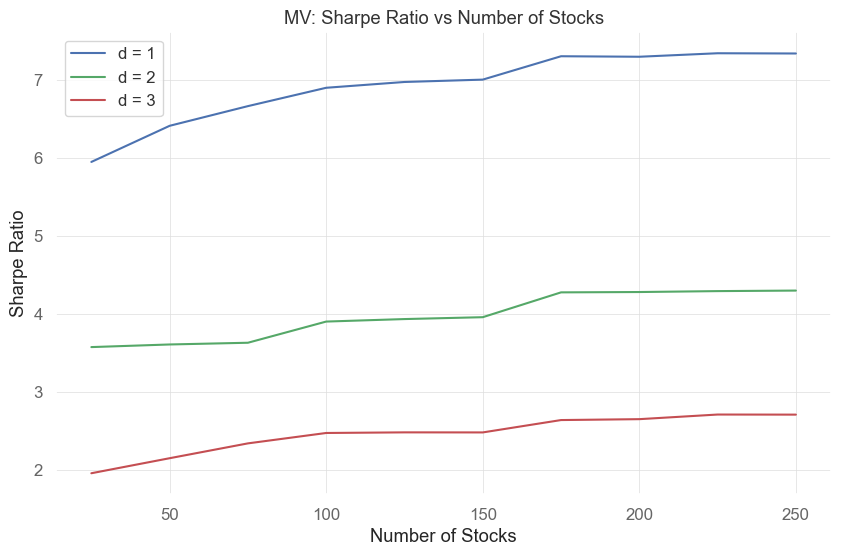

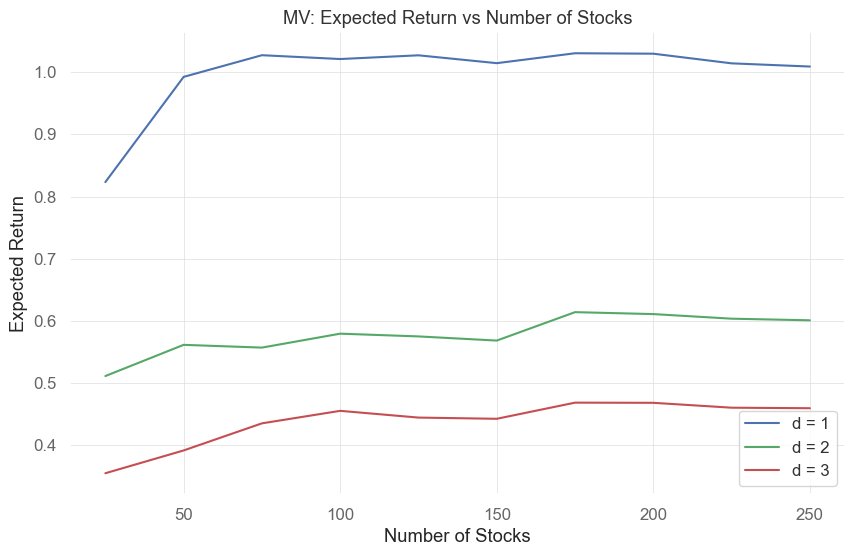

In [17]:
#Plot Graph results
#print(results)
# Make plot grid 2x2
#fig, axs = plt.subplots(2, 2, figsize=(10, 10))
d = [1, 2, 3]
for i, result in enumerate(results['dfs']):
    #print(i, result)
    plt.plot(result['num_stocks'], result['sharpes'])
    plt.xlabel('Number of Stocks')
    plt.ylabel('Sharpe Ratio')
    #plt.legend(['d = ' + str(d[i])])
    plt.title('MV: Sharpe Ratio vs Number of Stocks')
plt.legend(['d = 1', 'd = 2', 'd = 3'])
plt.show()

for i, result in enumerate(results['dfs']):
    #print(i, result)
    plt.plot(result['num_stocks'], result['expected_return'])
    plt.xlabel('Number of Stocks')
    plt.ylabel('Expected Return')
    # plt.legend(['d = ' + str(d[i])])
    plt.title('MV: Expected Return vs Number of Stocks')
plt.legend(['d = 1', 'd = 2', 'd = 3'])
plt.show()



                           Benchmark    Strategy
-------------------------  -----------  ----------
Start Period               2014-01-06   2014-01-06
End Period                 2019-11-29   2019-11-29
Risk-Free Rate             0.0%         0.0%
Time in Market             100.0%       100.0%

Cumulative Return          71.51%       127.62%
CAGR﹪                     6.52%        10.11%

Sharpe                     0.76         0.99
Prob. Sharpe Ratio         96.6%        99.13%
Smart Sharpe               0.76         0.98
Sortino                    1.05         1.4
Smart Sortino              1.05         1.4
Sortino/√2                 0.75         0.99
Smart Sortino/√2           0.74         0.99
Omega                      1.18         1.18

Max Drawdown               -19.78%      -24.0%
Longest DD Days            414          507
Volatility (ann.)          13.17%       15.26%
R^2                        0.76         0.76
Information Ratio          0.04         0.04
Calmar               

None

,Start,Valley,End,Days,Max Drawdown,99% Max Drawdown
1,2018-01-29,2018-12-24,2019-06-19,507,-24.002606,-20.179622
2,2015-07-17,2016-02-11,2016-07-05,355,-16.541462,-14.927583
3,2014-01-16,2014-04-11,2014-07-02,168,-10.212813,-9.595105
4,2016-08-24,2016-11-03,2016-11-16,85,-6.771218,-6.698603
5,2014-09-19,2014-10-13,2014-10-22,34,-6.062711,-5.605065


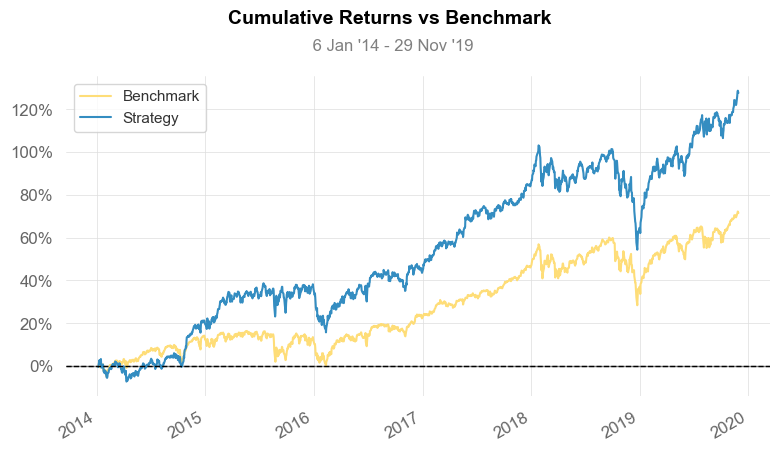

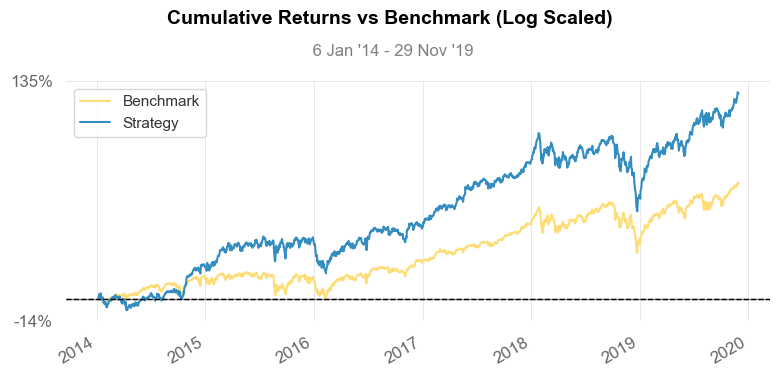

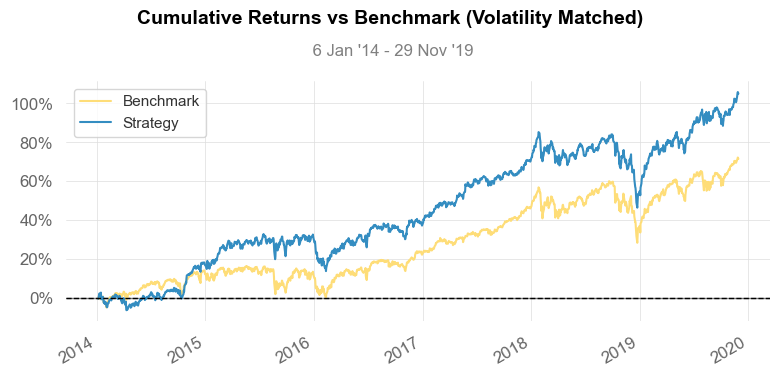

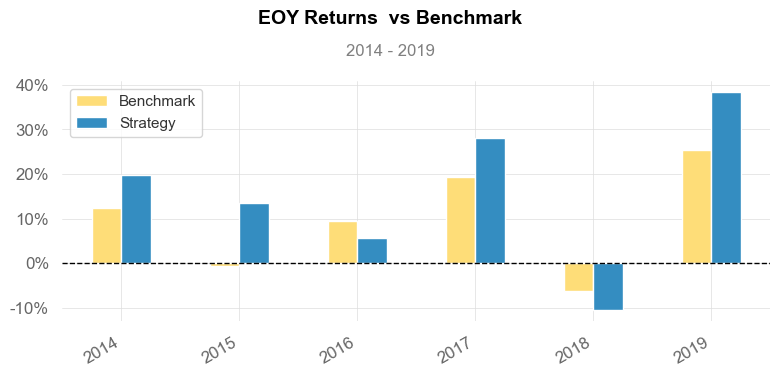

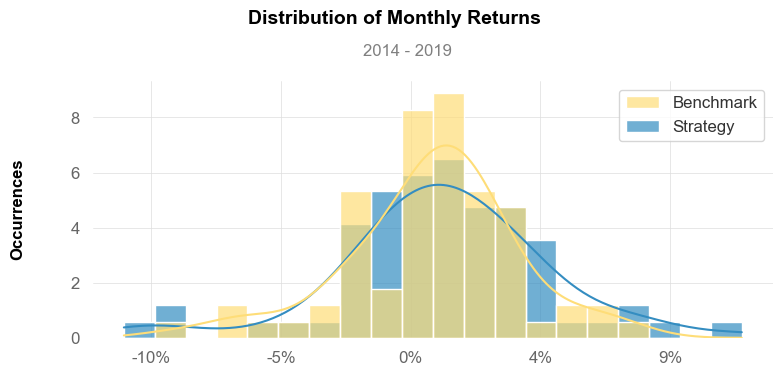

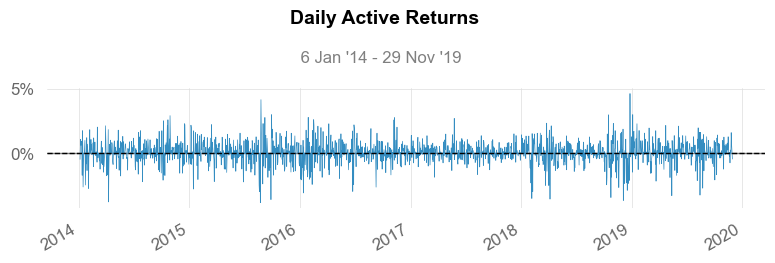

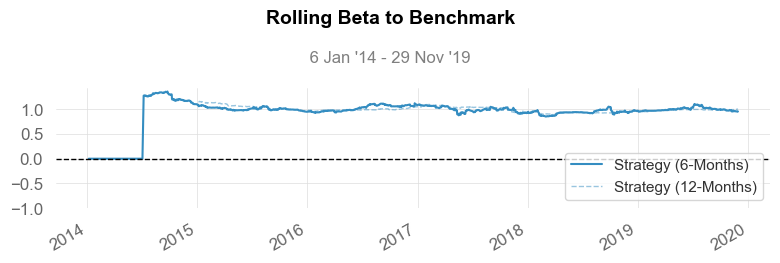

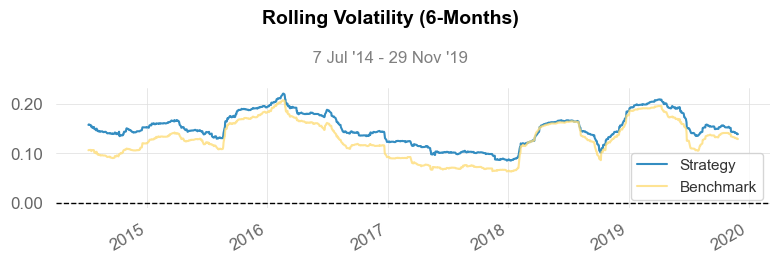

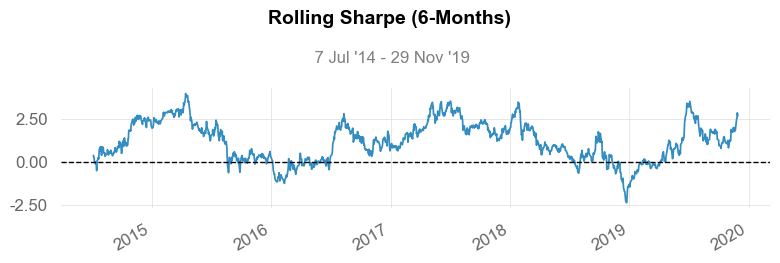

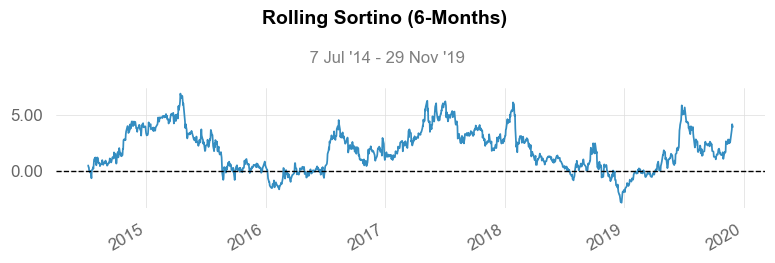

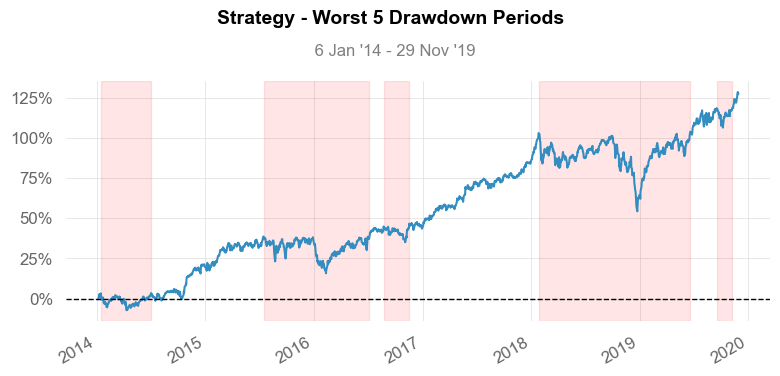

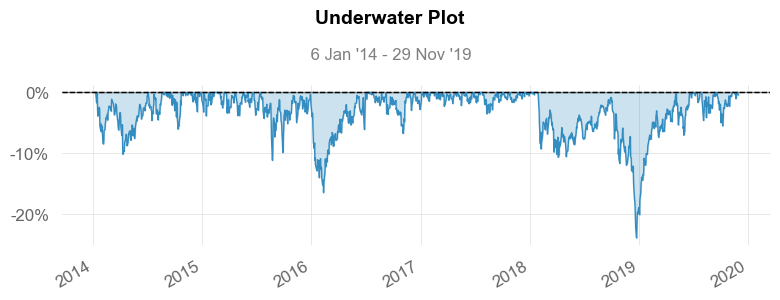

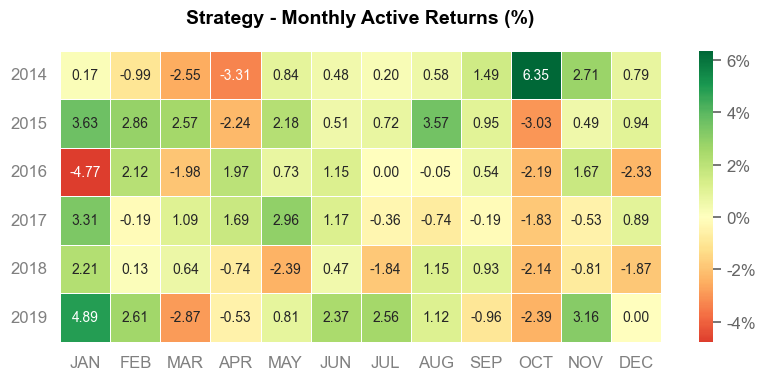

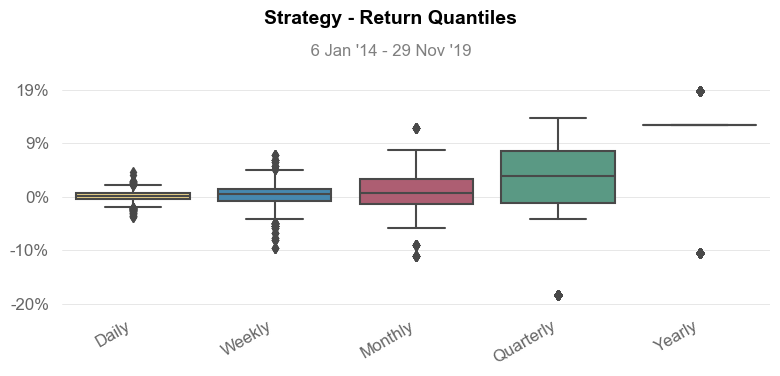

In [30]:
# Comparing with Quantstats Benchmark, Testing weights

# Maximum Sharpe Weighted Portfolio, testing with Optimized Weights
weights = results['dfs'][0]['weights'][-1] # Returns orderedDict of Stocks
#print(weights)

# For each stock, get the weights, get daily historical return from 2014-2018
# Get SP500 Benchmark
sp500 = pd.read_csv(DATA_DIR + 'GSPC.csv', index_col='Date', parse_dates=True)
mask = (sp500.index >= datetime(2014, 1, 1)) & (sp500.index <= datetime(2019, 12, 31))
sp500 = sp500.loc[mask]
sp500 = sp500['Close']
sp500 = sp500.pct_change().dropna()
#print(sp500)

returns = pd.DataFrame()
for ticker, weight in weights.items():
    
    # Get historical data for each stock
    if weight == 0:
        continue
    data = pd.read_csv(DATA_DIR + ticker + '.csv',
                           index_col='Date', parse_dates=True)
    mask = (data.index >= datetime(2014, 1, 1)) & (data.index <= datetime(2019, 11, 30))
    data = data.loc[mask]
    data = data['Close']
    data = data.pct_change().dropna()
    returns[ticker] = data * weight

returns['Portfolio'] = returns.sum(axis=1)
optimized_portfolio = returns['Portfolio']


qs.reports.full(optimized_portfolio, benchmark=sp500)
    
 


                           Benchmark    Strategy
-------------------------  -----------  ----------
Start Period               2014-01-03   2014-01-03
End Period                 2019-11-29   2019-11-29
Risk-Free Rate             0.0%         0.0%
Time in Market             100.0%       100.0%

Cumulative Return          148.02%      128.77%
CAGR﹪                     11.2%        10.16%

Sharpe                     0.99         1.0
Prob. Sharpe Ratio         99.14%       99.16%
Smart Sharpe               0.99         0.99
Sortino                    1.41         1.41
Smart Sortino              1.4          1.4
Sortino/√2                 0.99         1.0
Smart Sortino/√2           0.99         0.99
Omega                      1.18         1.18

Max Drawdown               -26.3%       -24.0%
Longest DD Days            515          507
Volatility (ann.)          16.96%       15.26%
R^2                        1.0          1.0
Information Ratio          -0.06        -0.06
Calmar                

None

,Start,Valley,End,Days,Max Drawdown,99% Max Drawdown
1,2018-01-29,2018-12-24,2019-06-19,507,-24.002606,-20.179622
2,2015-07-17,2016-02-11,2016-07-05,355,-16.541462,-14.927583
3,2014-01-16,2014-04-11,2014-07-02,168,-10.212813,-9.595105
4,2016-08-24,2016-11-03,2016-11-16,85,-6.771218,-6.698603
5,2014-09-19,2014-10-13,2014-10-22,34,-6.062711,-5.605065


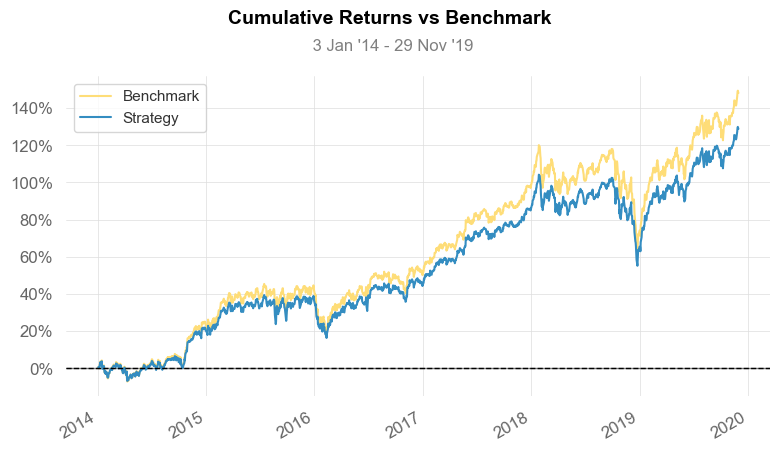

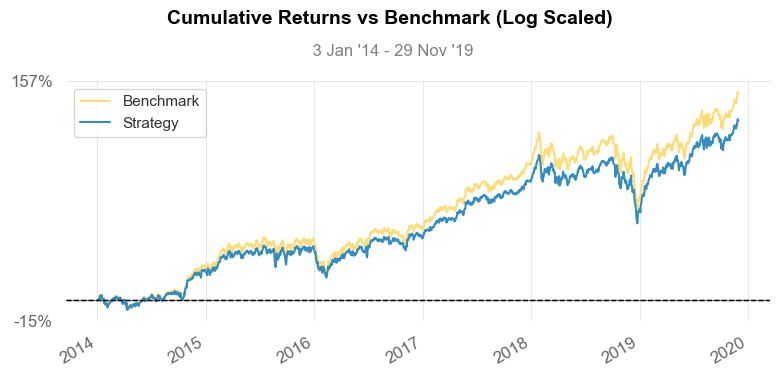

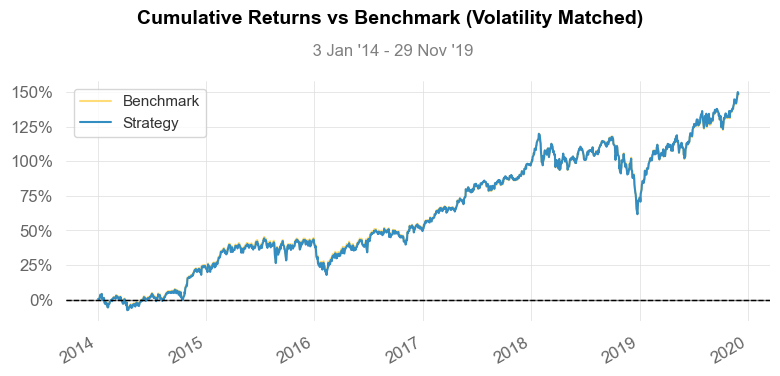

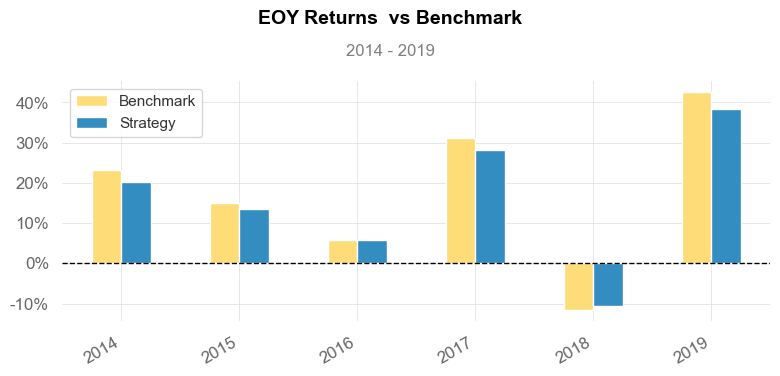

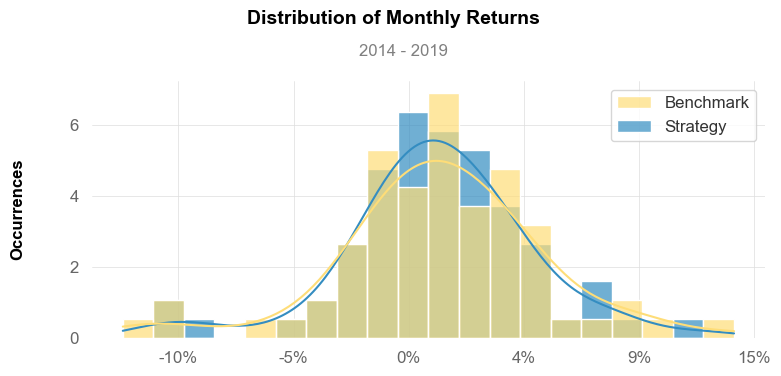

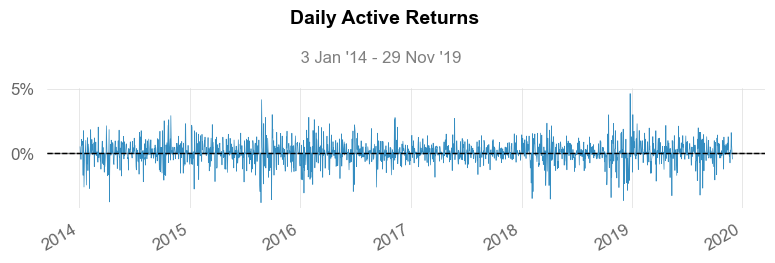

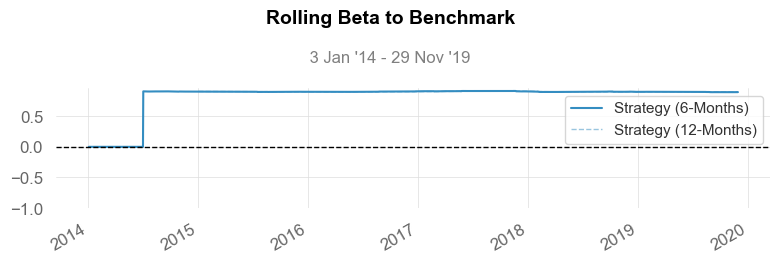

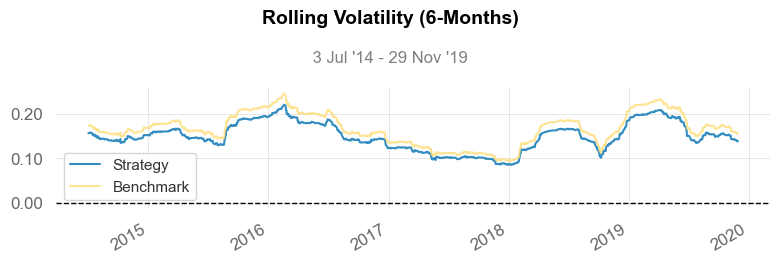

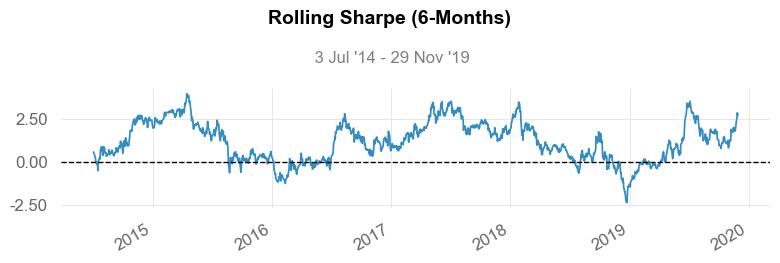

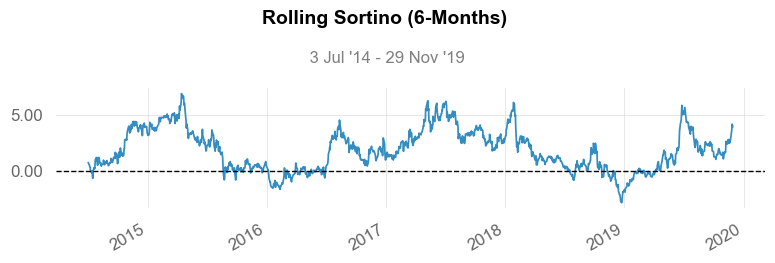

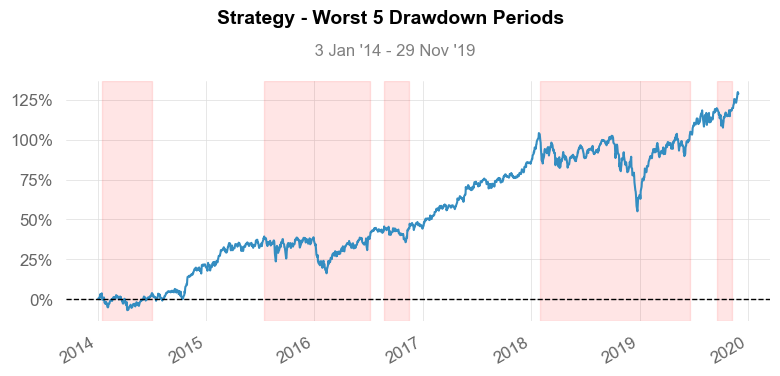

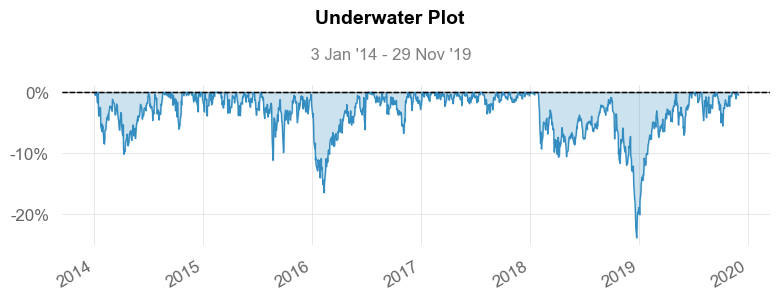

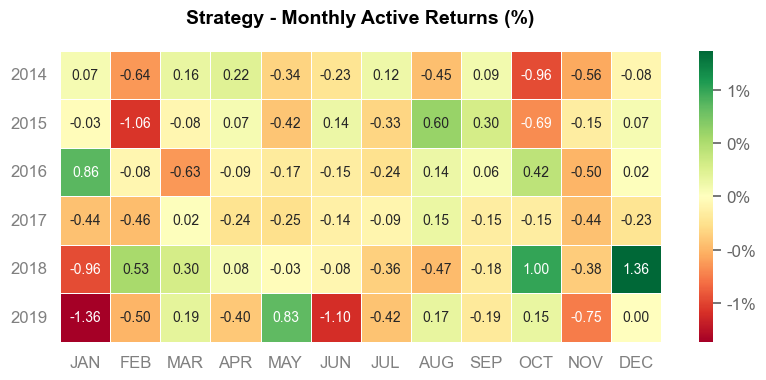

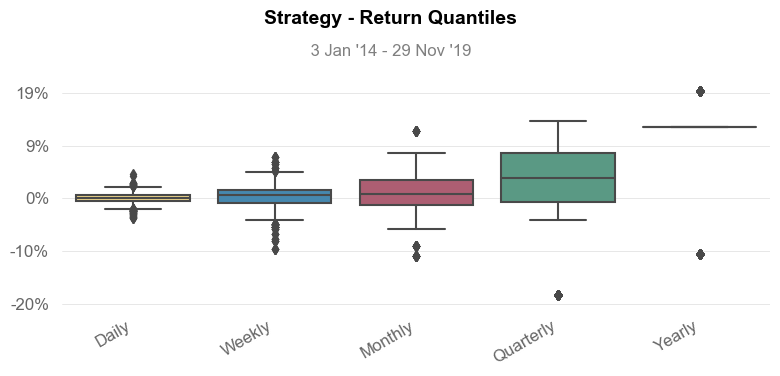

In [31]:
# Comparing with Quantstats Benchmark, Testing weights

# Maximum Sharpe Weighted Portfolio, testing with Native Weights
weights = results['dfs'][0]['weights'][-1]  # Returns orderedDict of Stocks
# print(weights)

# For each stock, get the weights, get daily historical return from 2014-2018

naive_returns = pd.DataFrame()
num_stocks = len(weights)
each_weight = 1 / num_stocks
for ticker, weight in weights.items():

    # Get historical data for each stock
    if weight == 0:
        continue
    data = pd.read_csv(DATA_DIR + ticker + '.csv',
                       index_col='Date', parse_dates=True)
    mask = (data.index >= datetime(2014, 1, 1)) & (
        data.index <= datetime(2019, 12, 31))
    data = data.loc[mask]
    data = data['Close']
    data = data.pct_change().dropna()
    returns[ticker] = data * each_weight

returns['Portfolio'] = returns.sum(axis=1)
portfolio = returns['Portfolio']


qs.reports.full(optimized_portfolio, benchmark=portfolio)
